In [1]:
import os
import h5py
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from collections import namedtuple
from scipy.ndimage import gaussian_filter
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
import math
import random
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotUniform
%matplotlib inline
from scipy import interpolate


In [11]:
params={'xtick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.rcParams['figure.dpi']=300

# Dynamics model architecture

In [2]:


ki = tf.keras.initializers.RandomNormal()

class CL_ConvNeuralNet(Model):
   
    def __init__(self, input_dims = [14,2], output_dims=[12]):
        
        self.initializer =  tf.keras.initializers.he_uniform()
        self.input_dims = input_dims
        self.output_dims = output_dims
        super(CL_ConvNeuralNet, self).__init__()
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.RMSprop()

    def build_model(self):
        InputImage = layers.Input(shape=(self.input_dims[0],1))
        InputNumeric = layers.Input(shape=(self.input_dims[1]))
        cnet = layers.Dense(512, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(InputImage)

        cnet = layers.Dense(512, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(cnet)
        
        cnet = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(cnet)
        
        
        cnet = layers.Flatten()(cnet)
        
        cnet = Model(inputs=InputImage, outputs=cnet)

        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(InputNumeric)

        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(numeric)
        
        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(numeric)

        numeric = Model(inputs=InputNumeric, outputs=numeric)

        combined = layers.concatenate([cnet.output, numeric.output])
        
        x = layers.Dense(512,activation=tf.nn.relu, kernel_initializer=self.initializer)(combined)
        x = layers.Dense(256,activation=tf.nn.relu, kernel_initializer=self.initializer)(x)
        combined_network = layers.Dense(self.output_dims[0],activation='linear', 
                                        kernel_initializer=self.initializer)(x)
    
        model = Model(inputs=[cnet.input, numeric.input], outputs=combined_network)

        return model
    
    # define forward pass
    def call(self, inputs):
        prediction = self.model(inputs)[:,:]

        return prediction


2023-05-26 11:47:33.796586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preprocessing utility functions for extracting domain wall from SPM image

In [3]:

start_pix = 55
end_pix = 70

def smooth_window(data, window_size):
    return np.convolve(data, np.ones((window_size,))/window_size, mode='valid')

def return_norm_wall_loc(am_img, start_pix = start_pix, end_pix = end_pix,
                        window_size=1):
    
    wps = np.zeros(shape=am_img.shape[0])
    for ind in range(am_img.shape[0]):
        wall_profile = smooth_window(am_img[ind,start_pix:end_pix], window_size)
        f = interpolate.interp1d(np.arange(len(wall_profile)), wall_profile, kind = 'nearest')
        xnew = np.linspace(0, len(wall_profile)-1, 128*10, endpoint = True)
        norm_wall_profile = np.argmax(np.diff(f(xnew)))
        subpix_max = xnew[norm_wall_profile]
        wps[ind] = subpix_max
    return wps


def normalize_images(input_images):
    return (input_images - np.min(input_images)) / (np.max(input_images) - np.min(input_images))

# Uploading and reading data from Dataset 1

In [4]:
folder = r'/Users/bry/Dropbox'
file_name = 'wall_pulsing_revised_smaller_PTO_40deg.p'
path_to_file = os.path.join(folder, file_name)
data = pickle.load(open(path_to_file, 'rb'))

Constants defined below: 128 pixels per domain wall

During the scan the wall was reset after 10 pulses were applied

Maximum bias = 10 V

Maximum pulse width = 500 ms

local_win_size used to include +/- 7 pixels from bias location

min and max ind ensure that bias location cannot be on very edge of domain wall profile

In [5]:
data_collected = data['results']
wall_bias_locs = data['wall_locs']

pix = 128
reset_freq = 10
max_bias = 10
max_pw = 500
window_size=3

local_win_size = 7
min_ind = 0.046875 
max_ind = 0.9 


In [6]:
phase_images = []
amp_images = []

for ind in range(len(data_collected)):
    output=np.asarray(data_collected[ind])
    amp_img = output[2].reshape(-1, pix*2)
    phase_img = output[3].reshape(-1, pix*2)

    amp_images.append(amp_img[:,:pix])
    phase_images.append(phase_img[:,:pix]) 

Extracting actions from SPM image data

In [7]:
l=0

actions = []
actions_norm = []

index_tracker =[]

for ind in range(len(data_collected)):

    
    if ind%reset_freq!=0:
        xpos,ypos = wall_bias_locs[l][3], wall_bias_locs[l][4] 
        bias_amp, bias_pw = wall_bias_locs[l][1], wall_bias_locs[l][2]


        xpos_norm = xpos/pix
        ypos_norm = ypos/pix
        bias_amp_norm = bias_amp/max_bias
        bias_pw_norm = bias_pw/max_pw
        index_tracker.append((ind,l))
        l+=1
    else:
        xpos = np.nan
        ypos = np.nan
        xpos_norm = np.nan
        ypos_norm = np.nan
        bias_amp = np.nan
        bias_pw = np.nan
        bias_amp_norm = np.nan
        bias_pw_norm = np.nan
        zero = np.nan
        one = np.nan
        two = np.nan
        three = np.nan
    
    actions.append([xpos,ypos, bias_amp, bias_pw])
    actions_norm.append([xpos_norm, ypos_norm, bias_amp_norm, bias_pw_norm])



# Uploading and reading data from Dataset 2

In [8]:
path = r'/Users/bry/Dropbox/New effort November 2022/wall pulsing/BE Version/'

all_img_bias=[]
for k in range(300,604):
    try:
        file_name_0 = path + 'Transition_k=' + str(k) + '.h5'
        h5_f0 = h5py.File(file_name_0, 'r+')
        bias_details0 = h5_f0['Measurement_000'].attrs['bias_details']
        h5_f0.close()
        bias_details0 = np.insert(bias_details0, 0, k)
        all_img_bias.append(bias_details0)
        k+=1
    except:
        print("Something went wrong:", k)
        k+=1

Something went wrong: 300
Something went wrong: 301


Extracting actions from SPM image data

In [9]:
m=0
amp = []
phase = []
for k in range(300,604): #start,stop
    try:
        file_name_0 = path + 'Transition_k=' + str(k) + '.h5'
        h5_f0 = h5py.File(file_name_0, 'r+')
        qf0 = h5_f0['Measurement_000']['sho_fit']['sho_fit']

        imamp = qf0[:,:,0]
        imphase = qf0[:,:,3]
        amp.append(imamp)
        phase.append(imphase)
        h5_f0.close()
        m+=1
    except:
        print("Something went wrong:", k)

Something went wrong: 300
Something went wrong: 301
Something went wrong: 303
Something went wrong: 304


We only want the images that have associated actions, so ignore the first few


In [10]:
all_img_bias = all_img_bias[2:]

amp_images_new = amp 
phase_images_new = phase 

# Dataset 1: Create transitions

In [12]:
phase_images_segmented = np.copy(amp_images)
phase_images_segmented = normalize_images(phase_images_segmented)
phase_images_segmented[phase_images_segmented<0.2] = 0
phase_images_segmented[phase_images_segmented>=0.4] = 1

In [13]:

transitions = []
transitions_norm = []
transitions_profiles = []
for ind in range(1, len(phase_images)):
    tnew = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_norm = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_prof = namedtuple('Transition', ['state','action', 'next_state'])
    
    tnew.state = phase_images_segmented[ind-1]
    tnew.next_state = phase_images_segmented[ind]
    tnew.action = actions[ind]
    
    tnew_norm.state = phase_images_segmented[ind-1]
    tnew_norm.next_state = phase_images_segmented[ind]
    tnew_norm.action = actions_norm[ind]
    
    state = tnew.state
    next_state = tnew.next_state
    shift, error, diffphase = phase_cross_correlation(state, next_state,
                                                  upsample_factor=3)
    offset_image = fourier_shift(np.fft.fftn(next_state), shift)
    offset_image = np.fft.ifftn(offset_image)
    next_state = offset_image.real
    wps = return_norm_wall_loc(state, window_size=window_size) + start_pix
    wps_next = return_norm_wall_loc(next_state,window_size=window_size) + start_pix
    
    tnew_prof.state = wps
    tnew_prof.action = tnew_norm.action
    tnew_prof.next_state = wps_next
    
    if not np.isnan(tnew.action[0]) and not np.isnan(actions[ind+1][0]):
        transitions.append(tnew)
        transitions_norm.append(tnew_norm)
        transitions_profiles.append(tnew_prof)

# Dataset 2: create transitions

In [14]:
l=0
bpw = []
bamp = []
for ind in range(1,301): 
    
    bias_amp, bias_pw = all_img_bias[l][1], all_img_bias[l][2]
    l+=1
    bpw.append(bias_pw)
    bamp.append(bias_amp)



In [15]:
l=0
actions_new = []
actions_norm_new = []
index_tracker_new =[]

for ind in range(1,301): 
    
     
    xpos,ypos = all_img_bias[l][-2], all_img_bias[l][-1] 
    bias_amp, bias_pw = all_img_bias[l][1], all_img_bias[l][2]
    bias_pw=bias_pw*1000

    xpos_norm = xpos/pix
    ypos_norm = ypos/pix
    bias_amp_norm = bias_amp/max_bias
    bias_pw_norm = bias_pw/max_pw
    index_tracker.append((ind,l))
    l+=1

    
    actions_new.append([xpos,ypos, bias_amp, bias_pw])
    actions_norm_new.append([xpos_norm, ypos_norm, bias_amp_norm, bias_pw_norm])

In [16]:
phase_images_segmented = np.copy(amp_images_new)
phase_images_segmented = normalize_images(phase_images_segmented)
phase_images_segmented[phase_images_segmented<0.2] = 0
phase_images_segmented[phase_images_segmented>=0.4] = 1

In [17]:

for ind in range(1, len(phase_images_new)):
    tnew = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_norm = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_prof = namedtuple('Transition', ['state','action', 'next_state'])
    
    tnew.state = phase_images_segmented[ind-1]
    tnew.next_state = phase_images_segmented[ind]
    tnew.action = actions_new[ind]
    
    tnew_norm.state = phase_images_segmented[ind-1]
    tnew_norm.next_state = phase_images_segmented[ind]
    tnew_norm.action = actions_norm_new[ind]
    
    state = tnew.state
    next_state = tnew.next_state
    shift, error, diffphase = phase_cross_correlation(state, next_state,
                                                  upsample_factor=3)
    offset_image = fourier_shift(np.fft.fftn(next_state), shift)
    offset_image = np.fft.ifftn(offset_image)
    next_state = offset_image.real
    wps = return_norm_wall_loc(state, window_size=window_size) + start_pix
    wps_next = return_norm_wall_loc(next_state,window_size=window_size) + start_pix
    
    tnew_prof.state = wps
    tnew_prof.action = tnew_norm.action
    tnew_prof.next_state = wps_next
    
    #if not np.isnan(tnew.action[0]) and not np.isnan(actions[ind+1][0]):
    transitions.append(tnew)
    transitions_norm.append(tnew_norm)
    transitions_profiles.append(tnew_prof)


# Function to create batches of transitions for model training

In [18]:
local_win_size = 7
offset=5
local_state_size = 14
train_fraction = 0.80
num_training_points = len(transitions_norm)

train_split_indices = np.random.choice(np.arange(len(transitions_norm)),
                                       (int(num_training_points*train_fraction)),
                                       replace = False)

test_split_indices = [val for val in np.arange(len(transitions_norm)) if val not in train_split_indices]

#Once we have the indices we need to make the training data. X_train, y_train, X_test, y_test
#X_train is the action, state, y_train is the state+1
#Same goes for X_test and y_test
X_train, y_train, X_test, y_test = [], [], [], []

for train_ind in train_split_indices:
    transition = transitions_norm[train_ind]
    trans_profile = transitions_profiles[train_ind]
    if transition.action[1] > min_ind and transition.action[1] < max_ind:
        wall_pos = transition.action[1]*128 + offset
        wall = np.array(trans_profile.state)
        local_wall = wall[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        local_wall = local_wall - np.mean(local_wall)
        lwall = np.zeros(local_state_size)
        lwall[:len(local_wall)] = local_wall
        lwall[len(local_wall):] = local_wall[-1]
        X_train.append([lwall, transition.action[2:]])
        difference_profile = trans_profile.next_state - trans_profile.state
        difference_profile[difference_profile>10]=10.0
        difference_profile[difference_profile<-10]=-10.0
        difference_profile = difference_profile/10
        difference_profile = difference_profile[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        dprof = np.zeros(local_state_size)
        dprof[:len(difference_profile)] = difference_profile
        dprof[len(difference_profile):] = difference_profile[-1]
        y_train.append(smooth_window(dprof,window_size=3))

for test_ind in test_split_indices:
    transition = transitions_norm[test_ind]
    trans_profile = transitions_profiles[test_ind]
    if transition.action[1] > min_ind and transition.action[1] < max_ind:
        wall_pos = transition.action[1]*128 + offset
        wall = np.array(trans_profile.state)
        local_wall = wall[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        local_wall = local_wall - np.mean(local_wall)
        lwall = np.zeros(local_state_size)
        lwall[:len(local_wall)] = local_wall
        lwall[len(local_wall):] = local_wall[-1]
        X_test.append([lwall, transition.action[2:]])
        difference_profile = trans_profile.next_state - trans_profile.state
        difference_profile[difference_profile>10]=10.0
        difference_profile[difference_profile<-10]=-10.0
        difference_profile = difference_profile/10
        difference_profile = difference_profile[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        dprof = np.zeros(local_state_size)
        dprof[:len(difference_profile)] = difference_profile
        dprof[len(difference_profile):] = difference_profile[-1]
        y_test.append(smooth_window(dprof,window_size=3))
    
def myGenerator(batch_size = 16, num_batches = 32, image_noise = 0.001,action_noise = 0.001):
    batch_num = 0
    while batch_num < num_batches:
        
        train_data_slice = np.random.choice(np.arange(len(X_train)),size = batch_size, replace = False)
        validation_data_slice = np.random.choice(np.arange(len(X_test)),
                                                 size = min(8,batch_size), replace = False)
        
        xtrain = [X_train[int(val)] for val in train_data_slice]
        ytrain = [y_train[int(val)] for val in train_data_slice]
        
        xtest = [X_test[int(val)] for val in validation_data_slice]
        ytest = [y_test[int(val)] for val in validation_data_slice]
        
        #Convert to tensorflow arrays - training data
        xtrain_images = np.zeros(shape=(batch_size, xtrain[0][0].shape[0]))
        for ind in range(len(train_data_slice)): 
            xtrain_images[ind,:] = xtrain[ind][0] + \
            np.random.normal(loc=0.0, scale = image_noise, size=(len(xtrain[ind][0])))                  
        xtrain_images = tf.stack(xtrain_images)
        
        xtrain_actions = np.zeros(shape=(batch_size, len(xtrain[0][1])))
        for ind in range(len(train_data_slice)): 
            xtrain_actions[ind,:] = xtrain[ind][1]
            
        xtrain_actions = tf.stack(xtrain_actions)
        xtrain = [xtrain_images[:,:,None], xtrain_actions]
        
        #Convert to tensorflow arrays - testing data
        xtest_images = np.zeros(shape=((len(xtest)), xtest[0][0].shape[0]))
        for ind in range(len(validation_data_slice)): 
            xtest_images[ind,:] = xtest[ind][0] + \
            np.random.normal(loc=0.0, scale = image_noise, size=(len(xtest[ind][0])))                    
        xtest_images = tf.stack(xtest_images)
        
        xtest_actions = np.zeros(shape=(len(xtest), len(xtest[0][1])))
        for ind in range(len(validation_data_slice)): 
            xtest_actions[ind,:] = xtest[ind][1] + np.random.normal(loc=0.0, scale = action_noise,size=(2))
            
        xtest_actions = tf.stack(xtest_actions)
        
        xtest = [xtest_images[:,:,None], xtest_actions]
        
        yield xtrain, tf.stack(ytrain), xtest, tf.stack(ytest)
        batch_num+=1

# Dynamics model training loop

In [19]:
ynet = CL_ConvNeuralNet()

stats = []
mygen = myGenerator(batch_size = 32, num_batches = 3000)
i=0
train_separate_branch = False 
penalty=2.0
#Let's write the training
ok_spectra=0
bad_spectra=0
num_batches = 32

mse = tf.keras.losses.MeanSquaredError()


model_name = 'trained_weights_5_12.h5'
model_path = os.path.join(os.path.abspath(os.getcwd()))
model_file = os.path.join(model_path,model_name)
ynet.built = True
ynet.model.load_weights(model_file)

2023-05-26 11:48:15.119417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/bry/opt/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


# Model testing

Let's see what the model's predictions look like on one of the validation sets...

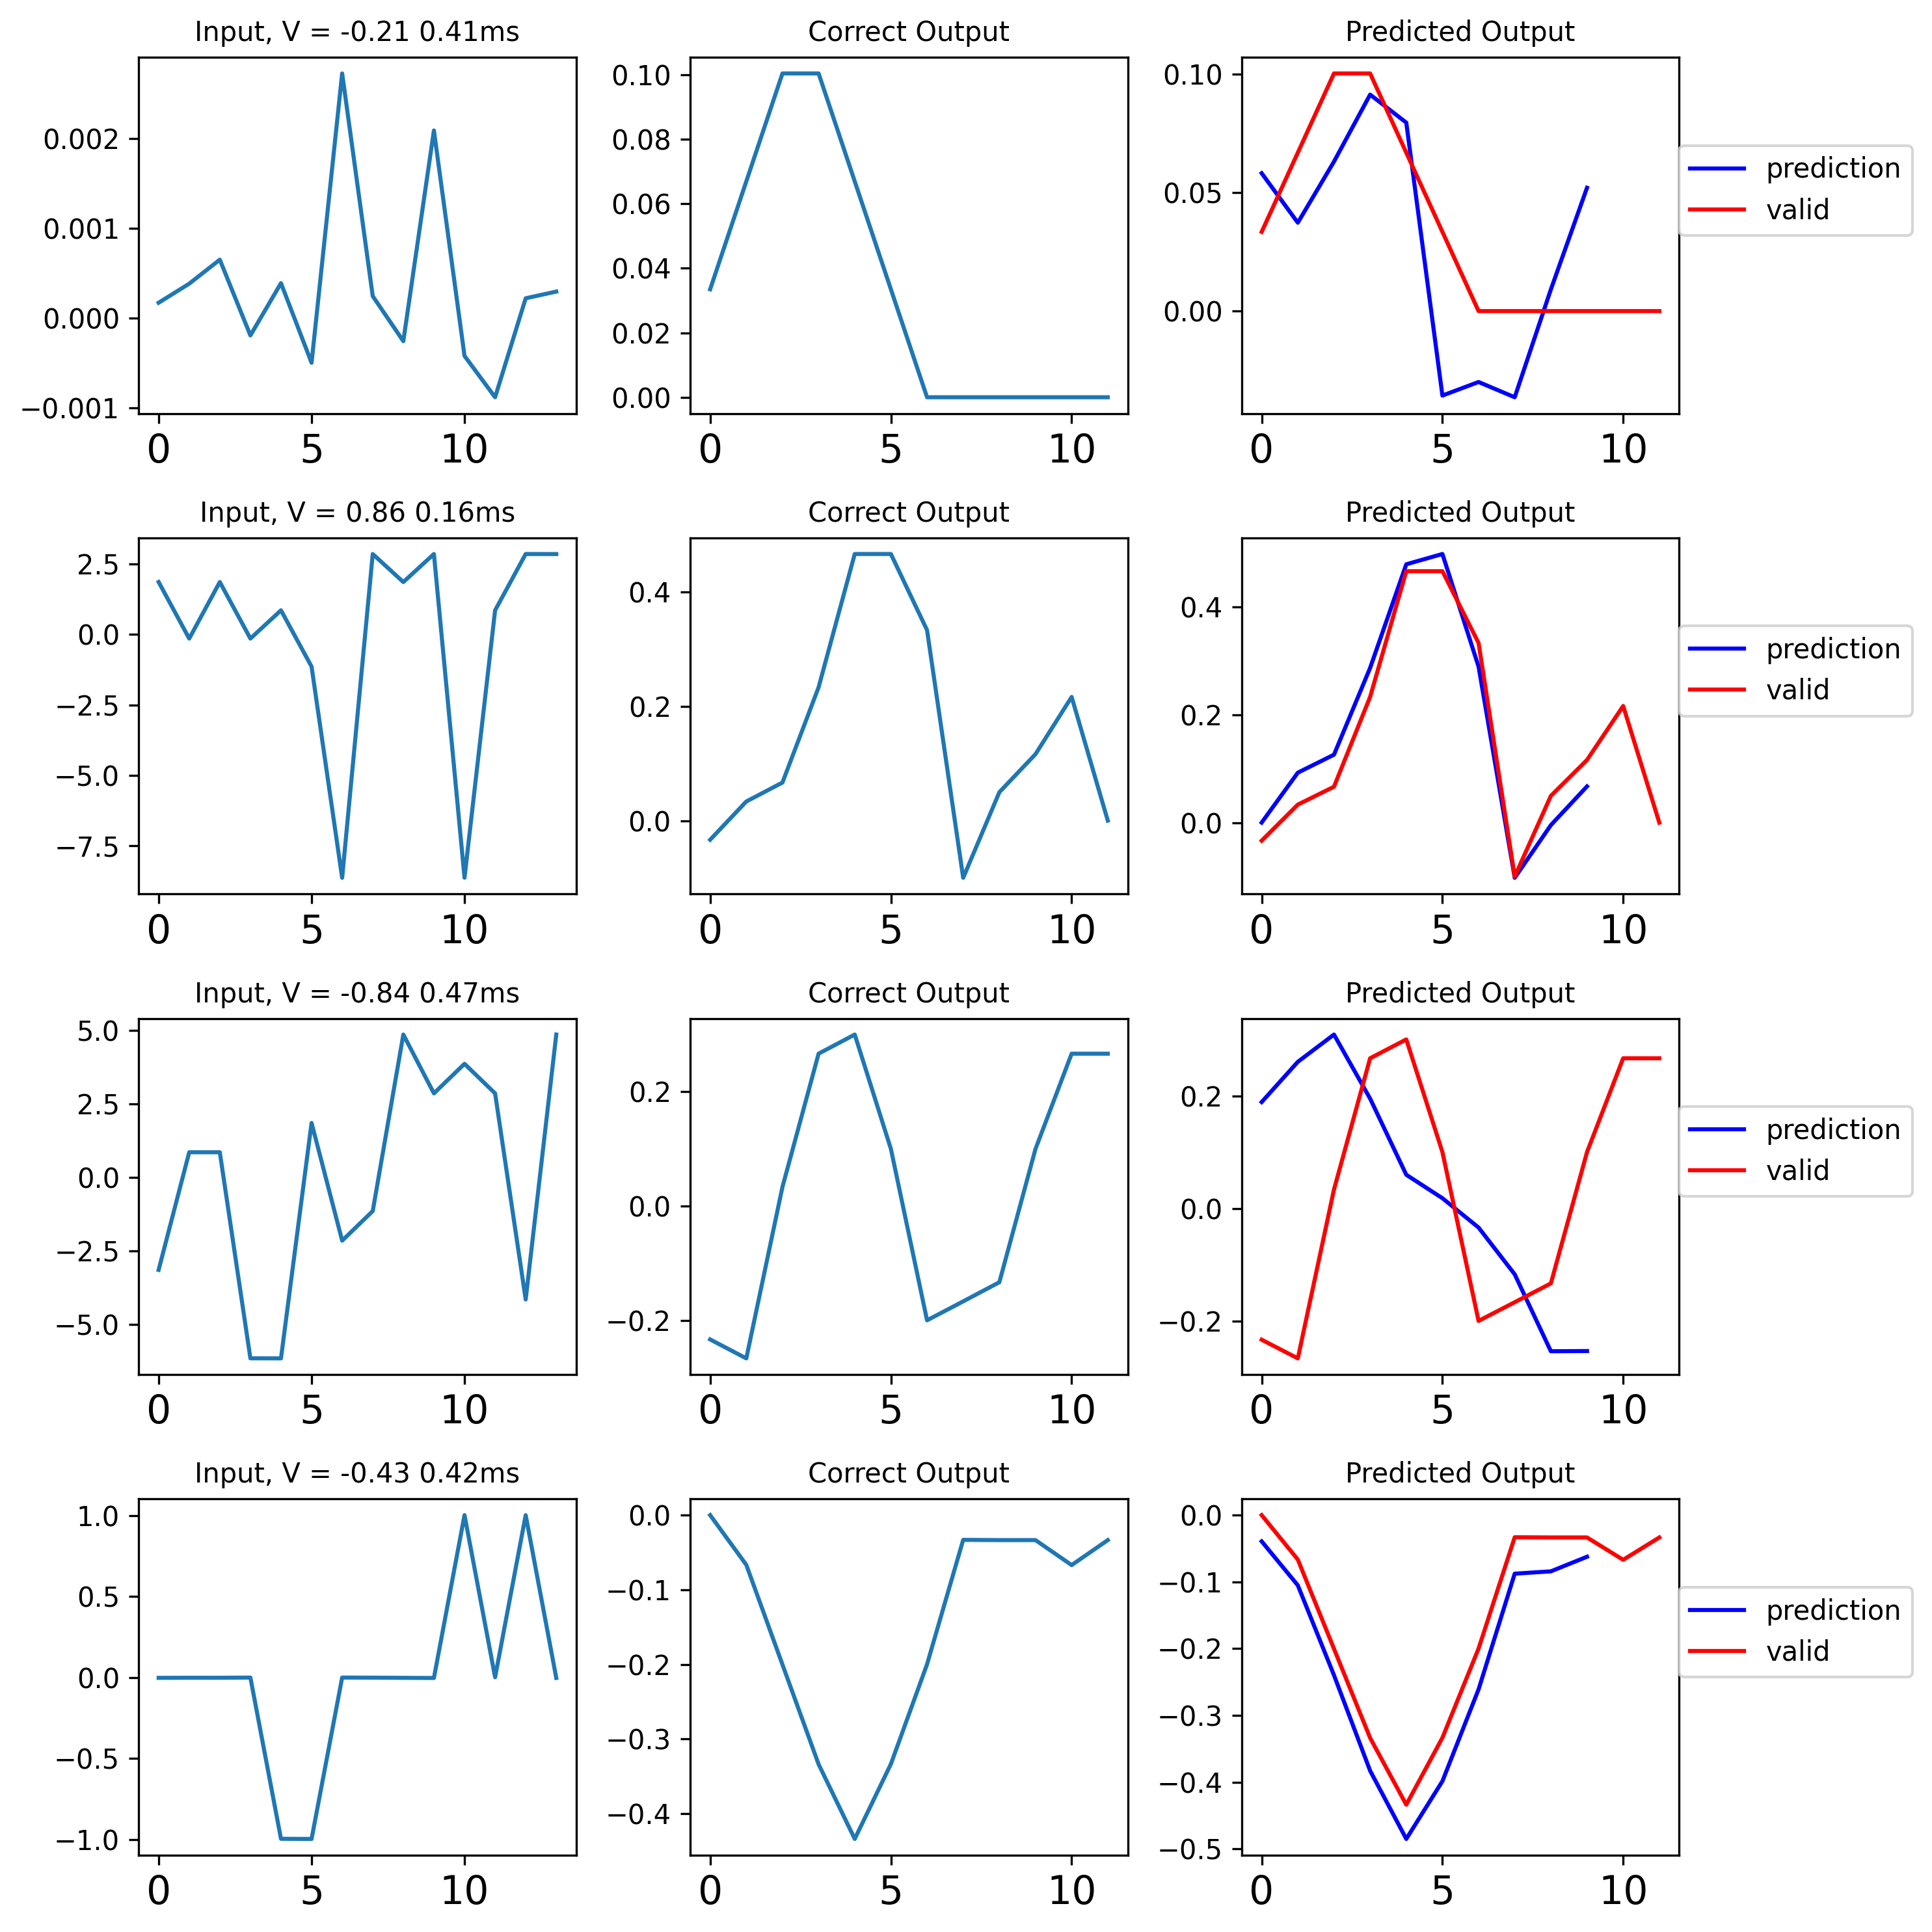

In [20]:
font_size = 10
mygen = myGenerator(batch_size = 4, num_batches = 10)

mxtrain, mytrain, mxvalid, myvalid = next(mygen)

predicted_wall = ynet(mxvalid)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize = (10,10))
for row in range(4):
    axes[row,0].plot(mxvalid[0][row,:])
    vval = mxvalid[1][row,0]
    pval = mxvalid[1][row,1]
    
    axes[row,0].set_title('Input, V = {:.2f} {:.2f}ms'.format(vval, pval), fontsize = 10)
    
    axes[row,1].set_title('Correct Output', fontsize = font_size)
    axes[row,1].plot(myvalid[row][:])
    
    axes[row,2].plot(predicted_wall[:,:-2][row], 'b-', label = 'prediction')
    axes[row,2].plot(myvalid[row][:], 'r-', label = 'valid')
    axes[row,2].set_title('Predicted Output', fontsize = font_size)
    axes[row,2].legend(loc = [1.0, 0.5])
    
fig.tight_layout()


Test dynamcis model across entire bias action space for a flat wall

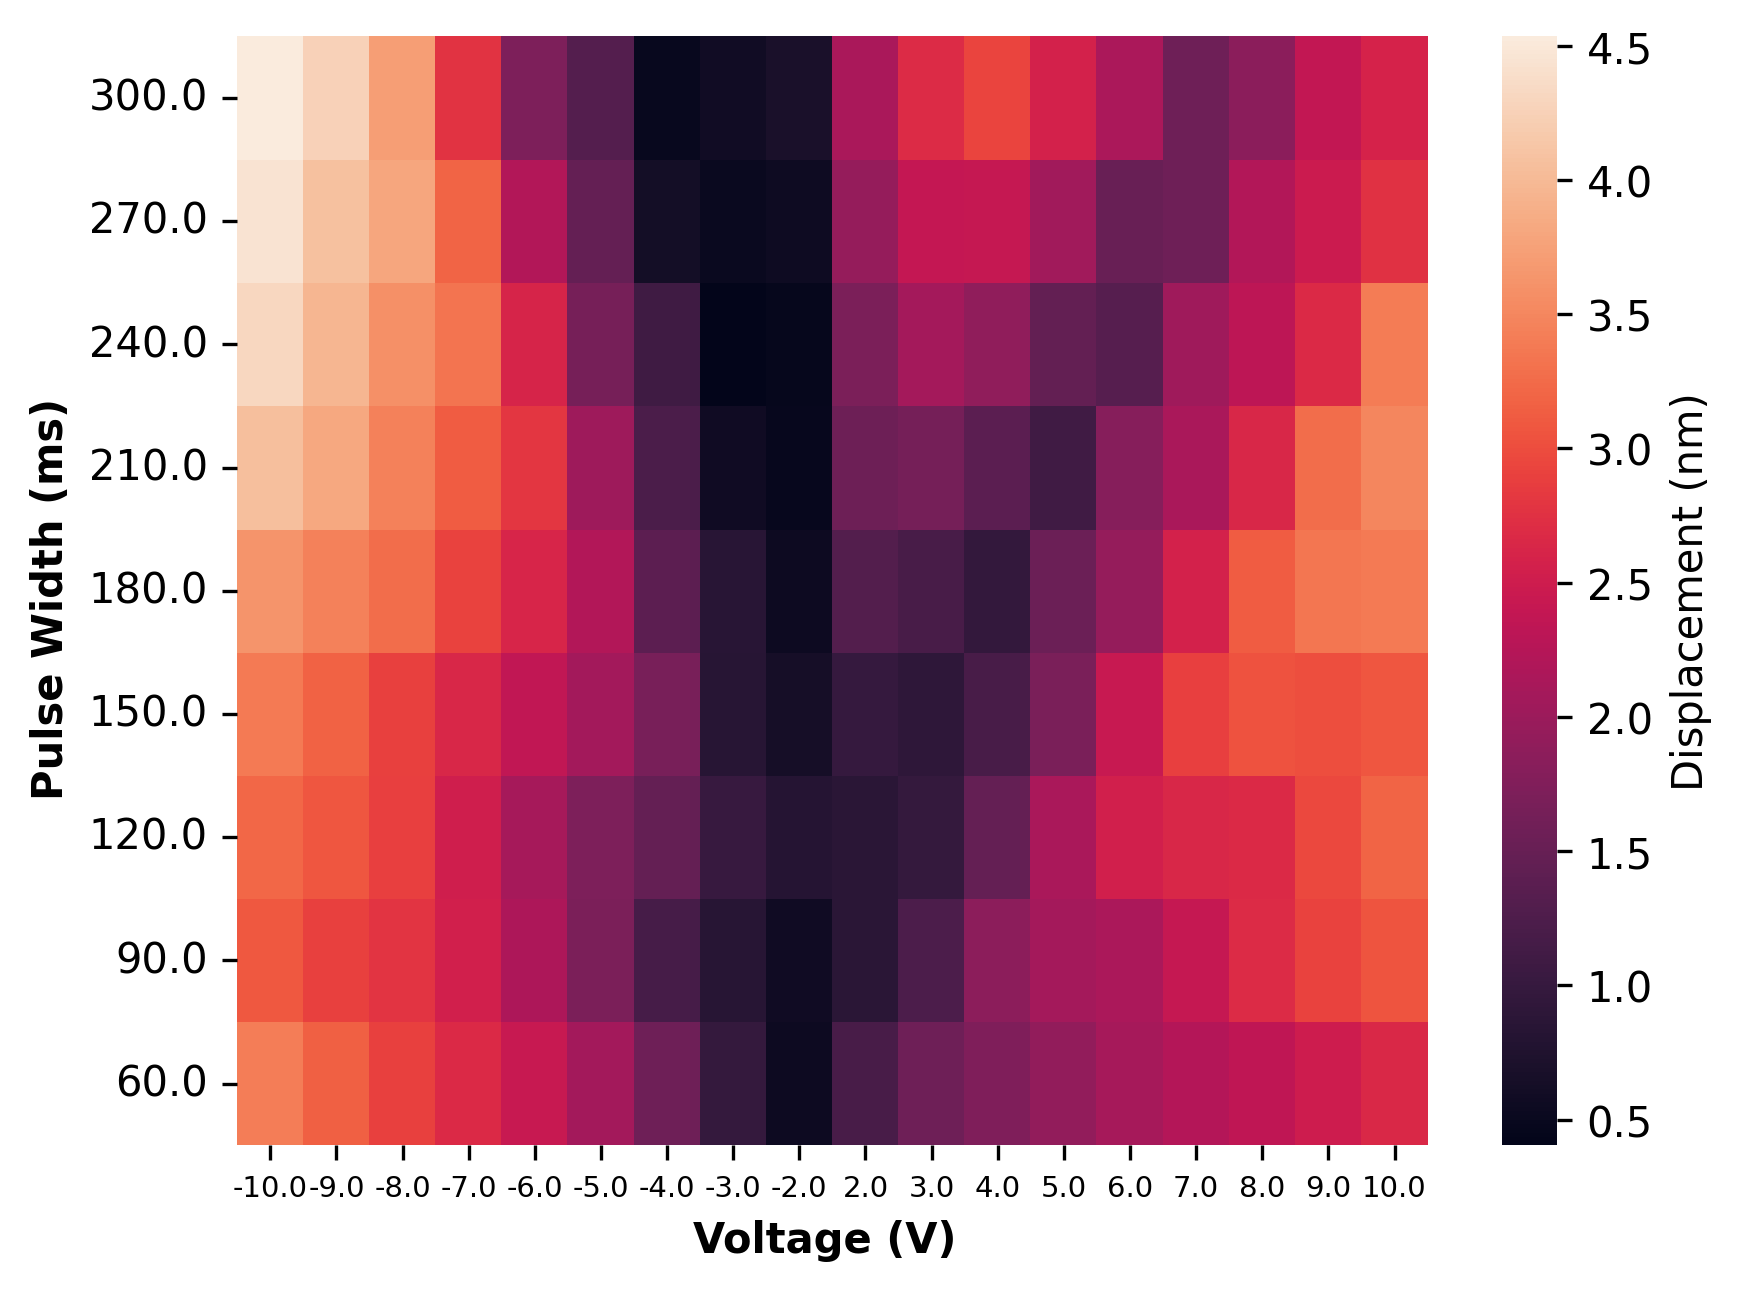

In [43]:

import pandas as pd
import seaborn as sns
#Let's take one prediction, and see how it varies with upping the bias
outputs = []

test_images, test_actions = [], []

test_image = np.full(14,-0.3)

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=p    
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])
        test_images.append(test_image)
test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
maxValues = df.abs().max(axis = 1)
maxValues=maxValues*7.8125 #convert to real values (nm)

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10 #convert to real values (V)
    temp=row[1]*300 #convert to real values (ms)
    row[1]=round(temp)
    new_actions.append(row)
    
actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(maxValues.to_frame(), left_index=True, right_index=True)

table = actionsdf.pivot('Pulse Width (ms)', 'Voltage (V) ')
ax = sns.heatmap(table[0],cbar_kws={'label': 'Displacement (nm)'})
og_table=table[0]
ax.invert_yaxis()
plt.yticks(rotation = 0)
plt.xticks(fontsize=7,rotation=0)
plt.xlabel('Voltage (V) ',fontweight='bold')
plt.ylabel('Pulse Width (ms) ',fontweight='bold')
plt.show()


Test dynamcis model across entire bias action space for a bulged wall

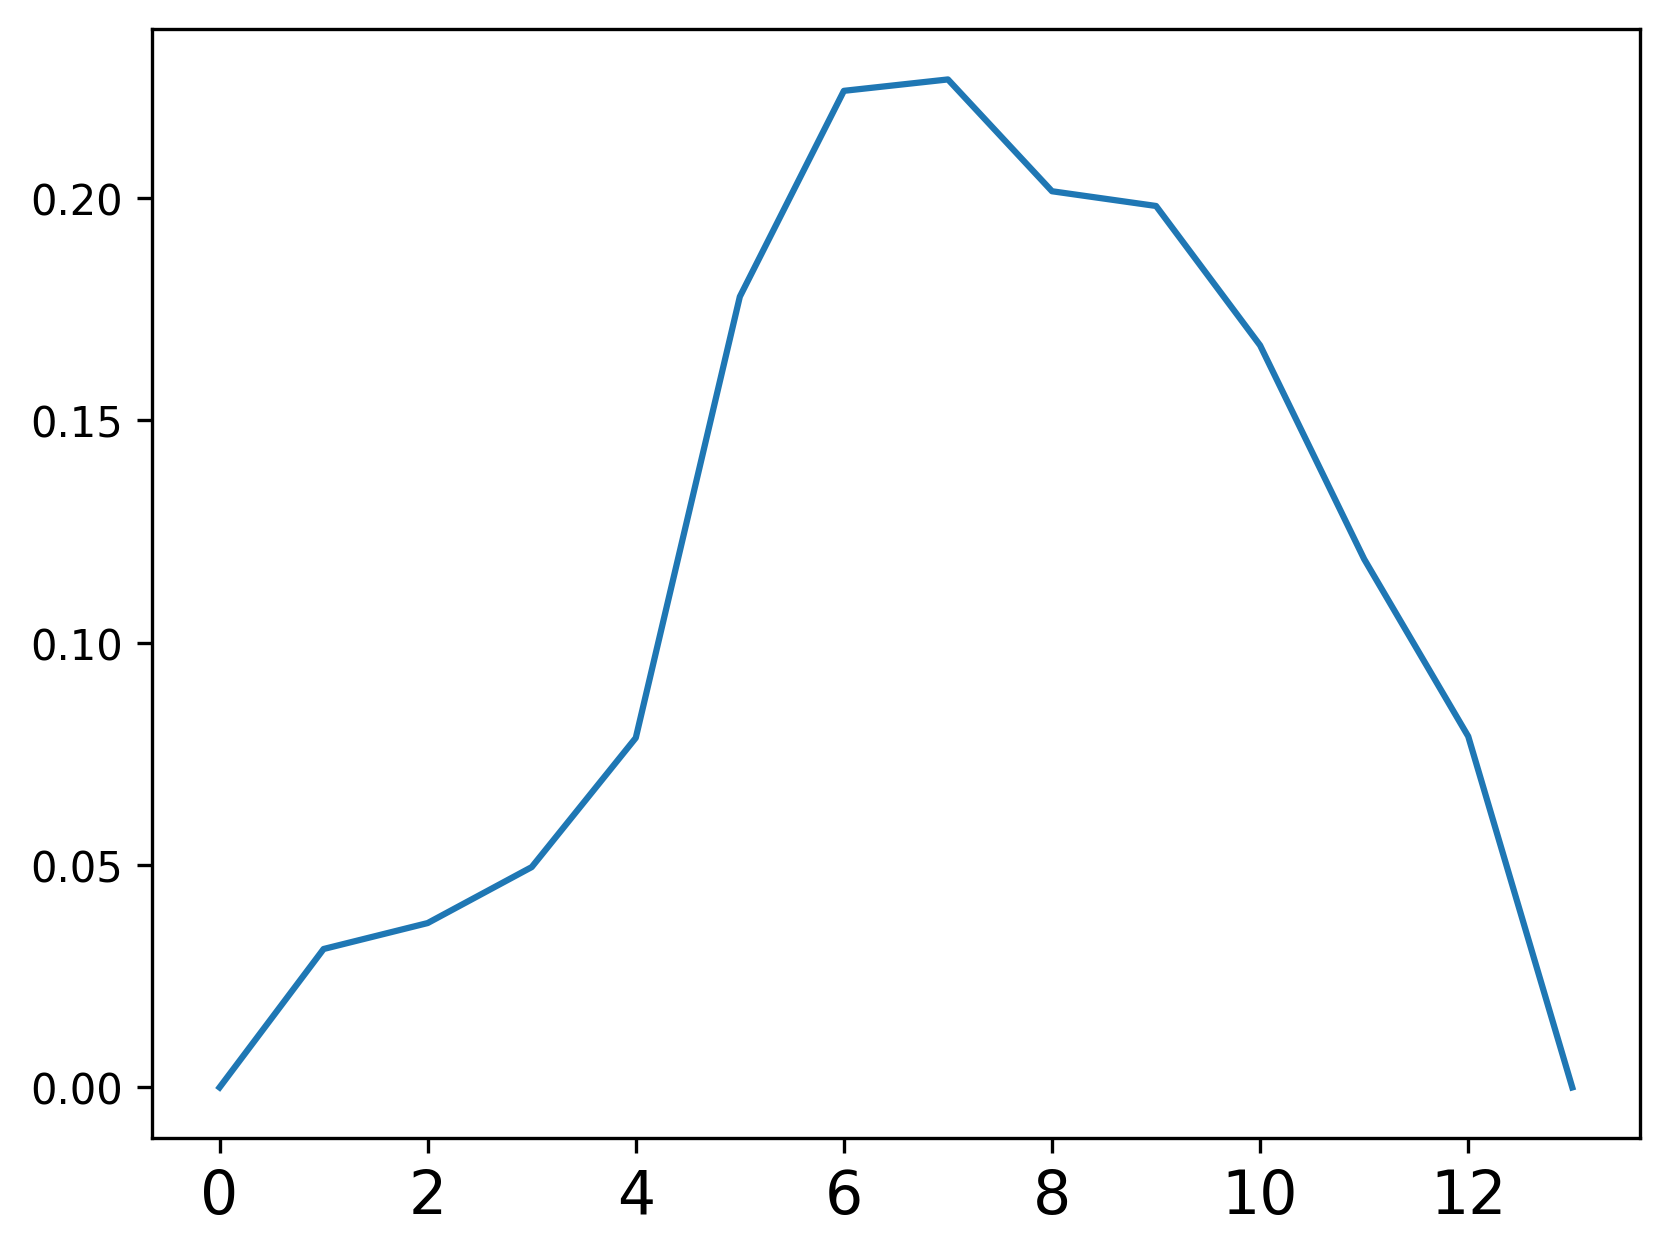

In [22]:
out = np.array(output[139])
out = np.pad(out, pad_width=1)
plt.plot(out)

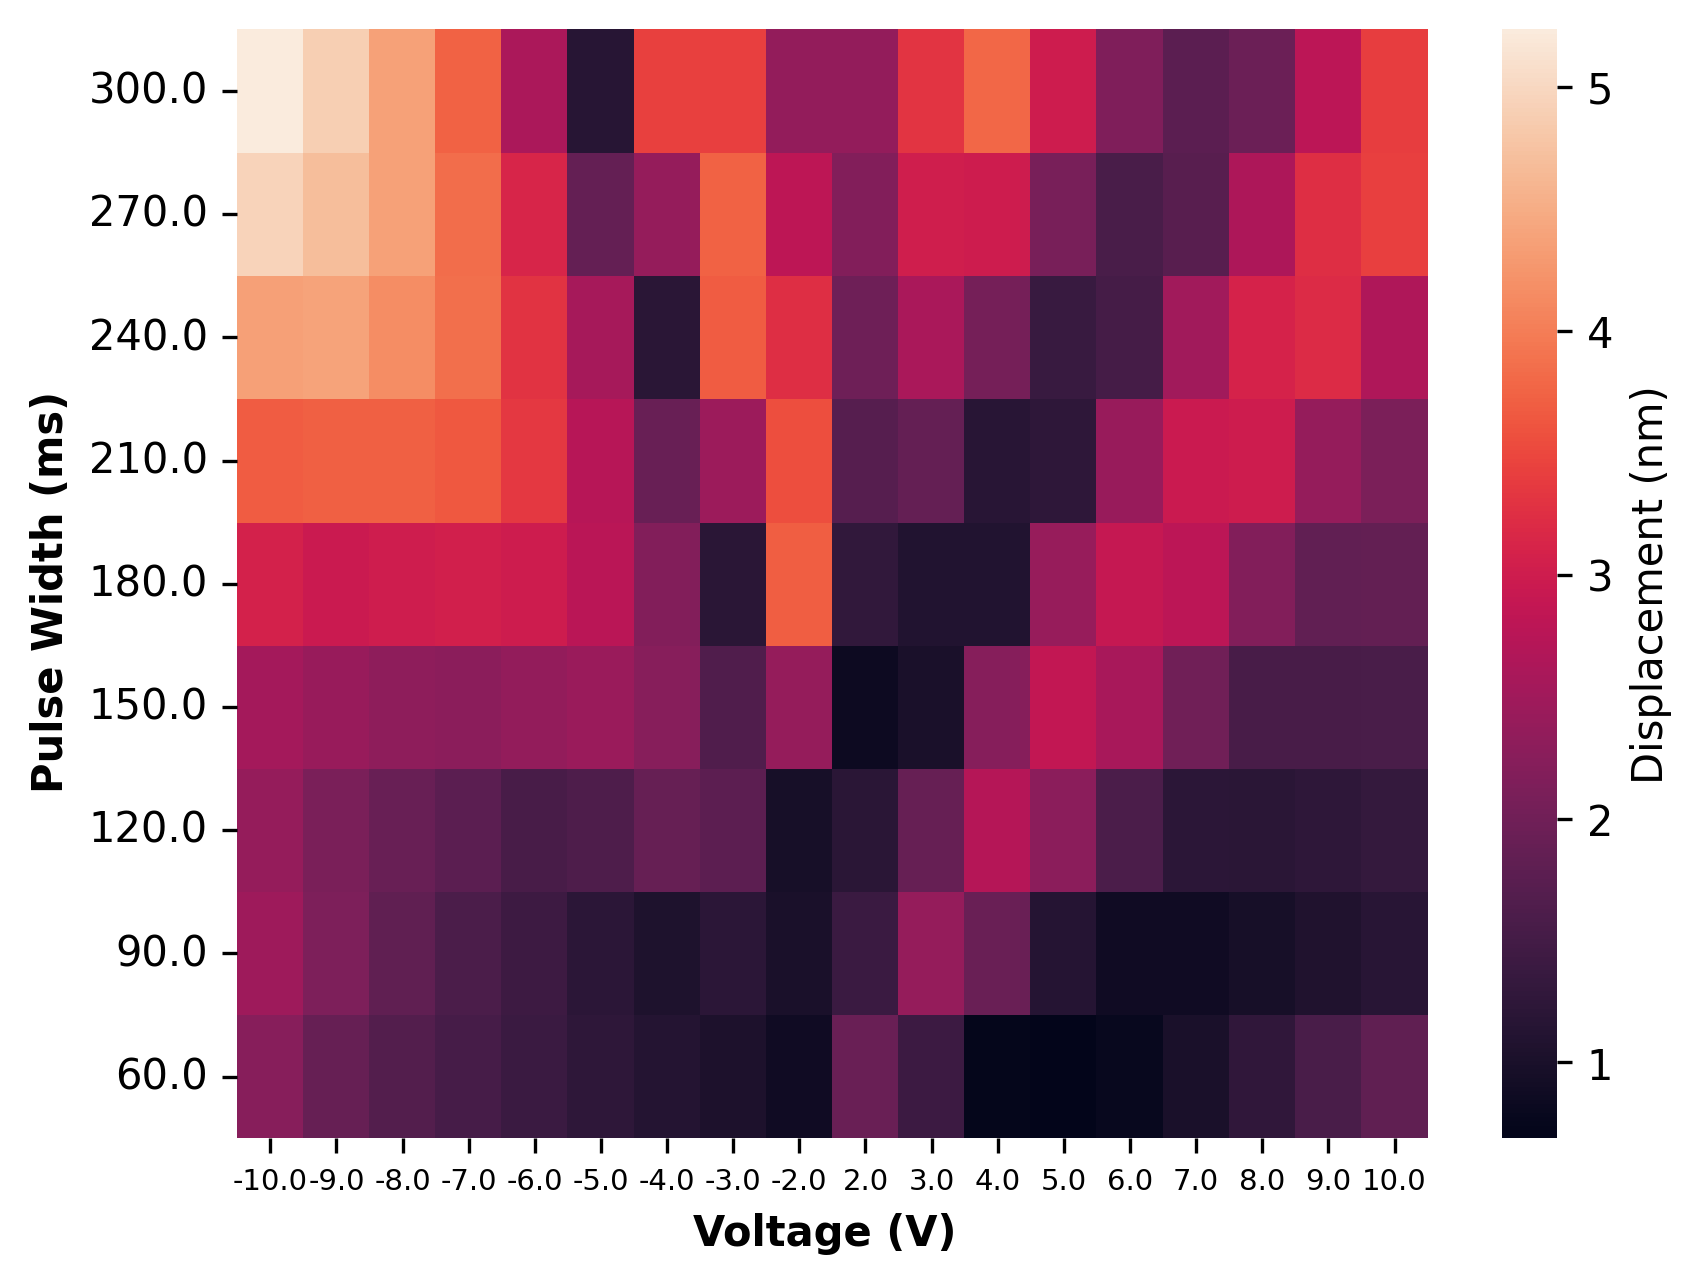

In [23]:
outputs = []

test_images, test_actions = [], []

test_image = out

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=p    
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])
        test_images.append(test_image)
test_input = [tf.stack(test_images), tf.stack(test_actions)] 

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
maxValues = df.abs().max(axis = 1)
maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*300
    row[1]=round(temp)
    new_actions.append(row)
    
actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(maxValues.to_frame(), left_index=True, right_index=True)

table = actionsdf.pivot('Pulse Width (ms)', 'Voltage (V) ')
ax = sns.heatmap(table[0],cbar_kws={'label': 'Displacement (nm)'})
bulged_table = table[0]
ax.invert_yaxis()
plt.yticks(rotation = 0)
plt.xticks(fontsize=7,rotation=0)
plt.xlabel('Voltage (V) ',fontweight='bold')
plt.ylabel('Pulse Width (ms) ',fontweight='bold')
plt.show()